In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Literal weights attached onto FPGA
a_ = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1]], dtype=np.int8)
a = a_.flatten()

In [3]:
def packetize(im):
    # Reverse the bits and chunk them up into 8 bit packets
    pic = list(reversed(im))
    pkts = []
    for i in range(0, len(pic), 8):
        pkts.append([0]*max(0, -(len(pic)-i-8)) + pic[max(0, len(pic)-i-8) : len(pic)-i])
    return pkts

def to_byte_pkts(pkts):
    byte_pkts = []
    for pkt in pkts:
        byte = ''.join([str(x) for x in pkt])
        # this will fail if x is not 0 or 1.
        byte = int(byte, 2)
        byte_pkts.append(byte)
    return byte_pkts

# Decoding side from FPGA:
def decode(byte_pkts):
    regs = []
    for pkt in byte_pkts:
        s = '{0:08b}'.format(pkt)
        regs.insert(0, s)

    data = [int(x) for s in regs for x in s]
    return data

# Mimicking the FPGA's behavior for XNORNET:
def predict(data, weights):
    # Now try to classify the 4:
    idx_max = 0
    max_val = 0
    for class_idx, row in enumerate(weights):
        rx = list(reversed(data))
        s = 0
        for a,b in zip(row, rx):
            s += a & b # (1-(a ^ b))
        if s > max_val:
            max_val = s
            idx_max = class_idx
    return idx_max

# Loading in Data

We must prune the # of classes down to 5 (`{0,1,2,3,4}`).

In [6]:
test_dataset = torchvision.datasets.MNIST(root='torch_dataset', 
                                          train=True, 
                                          transform=transforms.Compose([transforms.ToTensor()]),
                                          download=True)
dataset = list(test_dataset)
y = np.array([_x[1] for _x in dataset])
y = y[y < 5]
arr = np.load('matrices/bin_mnist_flat.npz.npy')

# Measuring the Accuracy

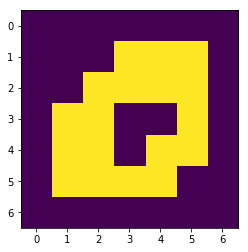

Ground truth : 0 vs. prediction : 0


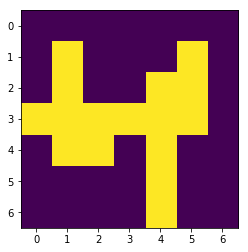

Ground truth : 4 vs. prediction : 4


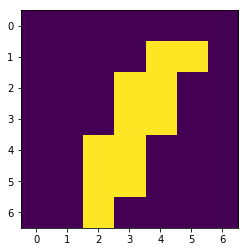

Ground truth : 1 vs. prediction : 1


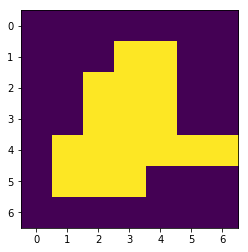

Ground truth : 2 vs. prediction : 2


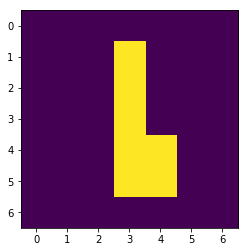

Ground truth : 1 vs. prediction : 1


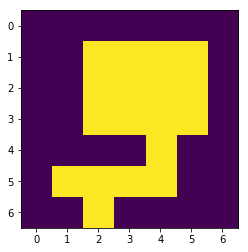

Ground truth : 3 vs. prediction : 3


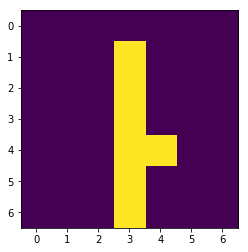

Ground truth : 1 vs. prediction : 1


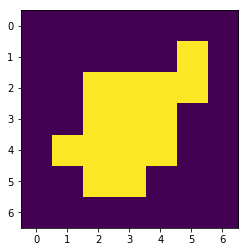

Ground truth : 4 vs. prediction : 4


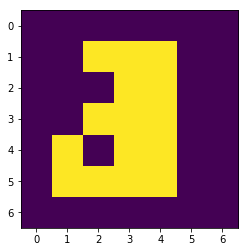

Ground truth : 3 vs. prediction : 3


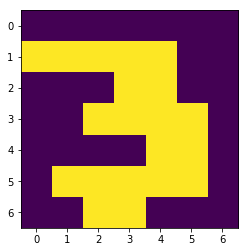

Ground truth : 3 vs. prediction : 3
Correct 10 out of 10


In [9]:
corrects = 0
n = 10
show_img = True
for i in range(0,n):
    bpkts = to_byte_pkts(packetize(arr[i]))
    data = decode(bpkts)
    result = predict(data, a_)
    
    if show_img:
        plt.imshow(arr[i].reshape(7,7))
        plt.show()
        print("Ground truth : {} vs. prediction : {}".format(y[i], result))
        
    corrects += y[i] == result
print("Correct {} out of {}".format(corrects, n))